# Assumptions

1. Maybe the biggest assumption we have is that people are entering their data correctly and taking the right amount of points. No one would ever lie on 8a.... [Mason](https://www.8a.nu/user/mason-caiby)
1. We're assuming that equally dedicated and motivated and genetically potentialled people are route climbing and bouldering (i.e. Route climbers aren't inheritantly better than boulderererers, even if they are).
2. We're assuming that the points gained by flashing vs onsighting are fair to both boulderers and sport climbers (some might argue one discipline is easier to 1st go than another). This also means that we're assuming flashing a route is about 1 letter grade harder than sending a route (I'd personally disagree) and that onsighting is 3 letter grades harder than flashing a route (this is really area dependent)
3. We're assuming that points gained are season independent. This is probably wrong. Ideally everyone is getting stronger all the time, if the Bubble, CO is anything to go off of, more people are bouldering outside in the winter than in the summer, so bouldering grades might be a little inflated. But, since we're doing worldwide, maybe the bouldering vs route season averages out?
4. We're assuming consistent popularity of bouldering and sport climbing throughout the world. This is tied to assumption number 1
5. We're assuming both disciplines pursue grades with equal vigor. If boulderers care more about grades than route climbers their score will be higher than sport climbers.
6. We're assuming equal tactics for sport climbers and boulderers. Essentially, that all climbers are trying to maximize their 8a.nu score, spending about a month per project and onsighting as hard as they can. Rifle climbers typically spend a season working a few routes, boulderers (where I'm from) seem to try a handleful of boulders at the same time. This means that boulderers probably send more 'limit' boulders than sport climbers?
7. Ok, look, I know BMI is a bad way to gauge someone's health. But it feels like an adequate way to compare muscle mass per height, right? Like, I'm assuming the top climbers are all relatively as lean as each other (like sub 10% bf for men?) and I want to know if being a Bufffff Boiiii (tm) is better than being a Skinni Salammi (also, tm). Well, really what I want to know is if getting my TinderBod 2019 is worth the risk of not climbing as hard this year. Existentially, is it worth trying to climb harder? When do the basic girls that swipe right for me stop caring about how hard I climb? When do I stop caring about how hard I climb. When will I love myself?

# Notes on the Plot
1. To determine a grade equivalency just find the ranking closest to your input grade and look at the average grade the same ranked person climbs in the output style. 
    1. Let's use 5.13c (8A+) as an example.
    2. Find the person that climbs, on average, 13C (10,500 8a.nu points).
    3. They're Ranked 455th
    4. Mouse over the graph and you can see the Boulderer ranked 455th's points
    5. They have 9490 points
    6. That's really close to 9500 8a.nu points, or v10.
    7. This means we can say that sending a v10 is about as impressive as climbing 5.13c
    8. Anecdotally, that lines up with my outdoor climbing experience (1-2 days for me to do either a 13c or v10).
1. Also, sorry. The BMI webscraper thing only kinda works. It seems like a hassle to get non-ascii characters included in the URL (or is it an IRI?). If someone wants to go for an improvement, great. You can send me a pull request, or just do it on your own thing. I literally dont care at all.
2. Also, the [8a robots.txt](https://www.8a.nu/robots.txt) webpage doesn't really discuss the `.../user/...` pages so I just kinda went for it. Please don't sue me. 
3. Scrapping the height/weight data is taking forever. It seems like 4 seconds per person, so... 4*3000 = 12000s = 200 minutes = 3.33 hours. I hope I dont accidentally delete that data. Although, it sounds liek you might be able to drop the time a bit if you turn off the printing. Your choice. You can also just not re-run this script ever and take my word for its accuracy.
4. I'm dropping all BMI's over 35. I spot checked a few users with BMI's that high and it seemed like they entered a joke weight or entered the wrong weight.
5. We're plotting the 30 person and 100 person rolling mean for BMI, the raw data is just too varied

In [1]:
%matplotlib inline
# -*- coding: utf-16 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pickle

# For plotly make sure you import plotly.offline etc. if you want it to save the graph
# as an html
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

sns.set(palette="muted")

# webscraping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

from bs4 import BeautifulSoup
import urllib3
import urllib.parse
from requests import get
import html5lib
import re
import os

# Web scrape

The obvious solution to grab all of the possible BMI data, e.g. avoid the ASCII / Unicode issue I ran into below is to just grabe the href associated with the name in the table while scraping the score data.

In [2]:
re_scrape = False

# this gets the points and names of the top 1500 sport climber and boulderers

if re_scrape:
    url_8a = 'https://www.8a.nu/scorecard/ranking/'
    driver = webdriver.Chrome(executable_path='./chromedriver')

    # 8a.nu is incredibly slow, so we're going to be doing this a lot
    driver.get(url_8a)
    driver.implicitly_wait(30)

    dfs = {'RankingRoute': None,
          'Boulder': None}

    for sport in dfs.keys():
        df = pd.DataFrame()
        for i in range(15):

            time.sleep(3)
            soup=BeautifulSoup(driver.page_source, "html.parser")
            table_id = 'ctl00_ContentPlaceholder_GridView' + sport
            table1 = soup.find('table', id=table_id)
            time.sleep(3)
            new_df = pd.DataFrame(pd.read_html(str(table1))[0])
            time.sleep(5)
            next_button_path = "//a[contains(@href,'GridView"+sport+"') and contains(.,'Next')]"
            next_routes = driver.find_element_by_xpath(next_button_path)
            actions = ActionChains(driver)
            actions.move_to_element(next_routes).perform()
            time.sleep(3)
            next_routes.click()

            df = pd.concat([df, new_df], axis=0)

        df.columns = ['ranking', 'drop','points', 'drop1','name','drop2','drop3','drop4']
        df.drop([column for column in df.columns if 'drop' in column], axis=1, inplace=True)
        df.dropna(inplace=True)
        df['points'] = df['points'].replace(r'\xa0', '', regex=True)
        df = df[~df.points.str.contains("Next 100")]
        df['points'] = df['points'].astype(int)
        dfs[sport] = df

    print('\a\a\a done')
    
else:
    with open('8a_data.pkl', 'rb') as handle:
        dfs = pickle.load(handle)

In [3]:
# this gets the BMI data (if possible) of the top 1500 sport climbers and boulderers
if re_scrape:
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36'
    names = dfs['RankingRoute'].name.values
    
    def scrap_bmi_data(names):
        names = [name.lower().replace(' ','-') for name in names]
        urls = ['https://www.8a.nu/user/'+name for name in names]
        heights = []
        weights = []
        for url in urls:
            url = urllib.parse.urlsplit(url)
            url = list(url)
            url[2] = urllib.parse.quote(url[2])
            url = urllib.parse.urlunsplit(url)
            # print(url)
            response = get(url, headers={'User-Agent':user_agent}, allow_redirects=True)

            soup = BeautifulSoup(response.text, 'html.parser')
            spans = soup('span')
            try:
                height = soup.find("td", text="Height").find_next_sibling("td").text
                # print(height)
                if height == '':
                    height = None
                else:
                    height = int(height.split(' ')[0])
                heights.append(height)

                weight = soup.find('td', text='Weight').find_next_sibling("td").text
                # print(weight)
                if weight =='':
                    weight = None
                else:
                    weight = int(weight.split(' ')[1])
                weights.append(weight)

            except AttributeError:
                heights.append(None)
                weights.append(None)

        return heights, weights

In [4]:
if re_scrape:
    names = dfs['RankingRoute'].name.values
    route_heights, route_weights = scrap_bmi_data(names)

    names = dfs['Boulder'].name.values
    boulder_heights, boulder_weights = scrap_bmi_data(names)

In [5]:
# add the newly made heights and weights to the correct dfs

if re_scrape:
    dfs['RankingRoute']['height'] = route_heights
    dfs['RankingRoute']['weight'] = route_weights
    dfs['Boulder']['height'] = boulder_heights
    dfs['Boulder']['weight'] = boulder_weights

In [6]:
# calculate and clean the bmis

dfs['RankingRoute']['bmi'] = dfs['RankingRoute']['weight'] / (dfs['RankingRoute']['height']/100)**2
dfs['Boulder']['bmi'] = dfs['Boulder']['weight'] / (dfs['Boulder']['height']/100)**2

dfs['RankingRoute']['bmi'] = dfs['RankingRoute']['bmi'].apply(lambda x: np.nan if x >= 35 else x)
dfs['Boulder']['bmi'] = dfs['Boulder']['bmi'].apply(lambda x: np.nan if x >= 35 else x)

dfs['RankingRoute']['rolling_bmi_30'] = dfs['RankingRoute']['bmi'].rolling(window=30, min_periods=1).mean()
dfs['Boulder']['rolling_bmi_30'] = dfs['Boulder']['bmi'].rolling(window=30, min_periods=1).mean()

dfs['RankingRoute']['rolling_bmi_100'] = dfs['RankingRoute']['bmi'].rolling(window=100, min_periods=1).mean()
dfs['Boulder']['rolling_bmi_100'] = dfs['Boulder']['bmi'].rolling(window=100, min_periods=1).mean()

In [7]:
# I don't want to do this by accident, and I don't want to accidentaly uncomment it.
# don't look at me

if False:
    with open('8a_data.pkl', 'wb') as pickle_file:
        pickle.dump(dfs, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

# The plotly Code starts here

For plotly make sure you import plotly.offline etc. if you want it to save the graph
as an html

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [22]:
# make a function to create the rolling bmi traces, they're pretty much the same.

def bmi_trace(x, y, color, name):
    rolling_bmi = go.Scatter(
        x = dfs['RankingRoute']['ranking'],
        y = dfs['RankingRoute']['rolling_bmi_100'],
        name = name,
        line = {'color': color},
        yaxis = 'y3',
        connectgaps = True,
        visible = "legendonly")
    return rolling_bmi

In [25]:
# define come colors
route_points_red = 'rgb(220,20,60)'
route_bmi_red = 'rgba(240,128,128,1)'

boulder_points_blue = 'rgb(100,149,237)'
boulder_bmi_blue =  'rgba(135,206,235, 1)'

# predefine some axis data
bmi_ticks = [a for a in np.linspace(start=19, stop=23, num=12)]
bmi_tick_labels = ['{:.2f}'.format(a) for a in bmi_ticks]

###############################

# Plotly Specific things

# Routes
route_points = go.Scatter(
            x = dfs['RankingRoute']['ranking'],
            y = dfs['RankingRoute']['points'],
            name='Route Points',
            line = {'color': (route_points_red)})

route_tick_vals = [val for val in range(8500, 14500, 500)]
route_tick_labels = ['7B+','7C','7C+', '8A','8A+', '8B', '8B+', '8C', '8C+', '9A' ,'9A+', '9B','9B+']

# Boulders
bouldering_points = go.Scatter(
            x = dfs['Boulder']['ranking'],
            y = dfs['Boulder']['points'],
            name = 'Bouldering Points',
            yaxis = 'y2',
            line = {'color': (boulder_points_blue)})

boulder_tick_vals = [val for val in range(7000,13000, 500)]
boulder_tick_labels = ['v5','v6','v7','v8', 'v9', 'v10', 'v11', 'v12','v13','v14','v15', 'v16', 'v17', 'v18']

# Rolling Route BMI
route_rolling_bmi_100 = bmi_trace(dfs['RankingRoute']['ranking'], 
                                  dfs['RankingRoute']['rolling_bmi_100'],
                                  route_bmi_red,
                                  "100 Person Rolling Route BMI")

route_rolling_bmi_30 = bmi_trace(dfs['RankingRoute']['ranking'], 
                                 dfs['RankingRoute']['rolling_bmi_30'],
                                 route_bmi_red,
                                 "30 Person Rolling Route BMI")

# Rolling Boulder BMI
boulder_rolling_bmi_100 = bmi_trace(dfs['Boulder']['ranking'],
                                    dfs['Boulder']['rolling_bmi_100'],
                                    boulder_bmi_blue,
                                    "100 Person Rolling Bouldering BMI")


boulder_rolling_bmi_30 = bmi_trace(dfs['Boulder']['ranking'],
                                   dfs['Boulder']['rolling_bmi_30'],
                                   boulder_bmi_blue,
                                   "30 Person Rolling Bouldering BMI")

############
""" The traces are the lines etc. The layout affects the graph."""
############

data = [route_points,  route_rolling_bmi_100, route_rolling_bmi_30,
        bouldering_points, boulder_rolling_bmi_100, boulder_rolling_bmi_30]

layout = go.Layout(
            title = 'Comparison of Points by 8a Ranking',
            xaxis = {'title': 'Ranking',
                     'domain': [0.1,1]},
    
            # route rankings
            yaxis = {'title':'Route Points',
                     'tickvals': route_tick_vals,
                     'ticktext': route_tick_labels,
                     'range': [8500,14000],
                     'titlefont': {'color': route_points_red},
                     'tickfont': {'color': route_points_red},
                     'anchor':'x'},
    
            # bouldering rankings
            yaxis2 = {'title': 'Bouldering Points',
                      
                     'tickvals': boulder_tick_vals,
                     'ticktext': boulder_tick_labels,
                     'titlefont': {'color': boulder_points_blue},
                     'tickfont': {'color': boulder_points_blue},
                     'overlaying': 'y',
                     'side': 'right',
                     'range': [7000,12500],
                     'anchor':'x'},
    
            # bmi
            yaxis3 = {'title': 'Rolling BMI',
                     'tickvals': bmi_ticks,
                     'ticktext': bmi_tick_labels,
                     'range': [19,23],
                     'overlaying': 'y',
                     'titlefont': {'color': 'black'},
                     'tickfont': {'color': 'black'},
                     'position': 0.025,
                     'anchor': 'free'}
        )


# make the figure
fig = go.Figure(data=data, layout=layout)
# export to html
plot_url = plot(fig)

In [26]:
for df in dfs.values():
    print(df.head())

  ranking  points               name  height  weight        bmi  \
0       1   13835         Adam Ondra   185.0    68.0  19.868517   
1       2   13415        Piotr Schab   173.0    58.0  19.379197   
2       3   13127  Jonathan Siegrist   167.0    58.0  20.796730   
3       4   13030      Pirmin Bertle   184.0    68.0  20.085066   
4       5   12903   Jorge diaz-rullo     NaN     NaN        NaN   

   rolling_bmi_30  rolling_bmi_100  
0       19.868517        19.868517  
1       19.623857        19.623857  
2       20.014815        20.014815  
3       20.032378        20.032378  
4       20.032378        20.032378  
  ranking  points               name  height  weight        bmi  \
0       1   11945       Daniel Woods   166.0    63.0  22.862534   
1       2   11880  Giuliano Cameroni   170.0    53.0  18.339100   
2       3   11850         James Webb   183.0    78.0  23.291230   
3       4   11720     Martin Stráník   178.0    73.0  23.040020   
4       5   11690     Christof Rauch   1

Routes
r^2 value: 0.005191141584609427


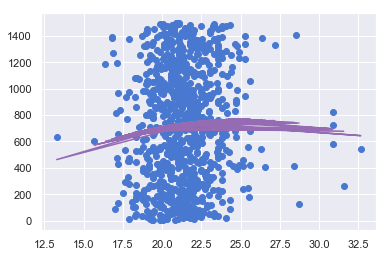

Boulders
r^2 value: 0.0015524910742533704


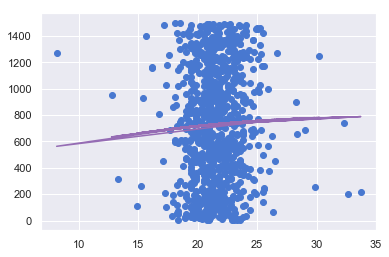

In [45]:
# let's see if we can predict ranking from bmi

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def bmi_to_rank(df):
    x = df['bmi'].values.reshape(-1, 1)
    y = df['ranking'].astype('int')
    
    polynomial_features= PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(x)
    
    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)

    print('r^2 value:', r2_score(y, y_poly_pred))
    plt.scatter(x, y)
    plt.plot(x, y_poly_pred, color='m')
    plt.show()
    
# routes
print('Routes')
df = dfs['RankingRoute'].dropna(axis=0)
bmi_to_rank(df)

# boulder
print('Boulders')
df = dfs['Boulder'].dropna(axis=0)
bmi_to_rank(df)

# That's a pretty strong no

Routes
r^2 value: 0.005438739837619111


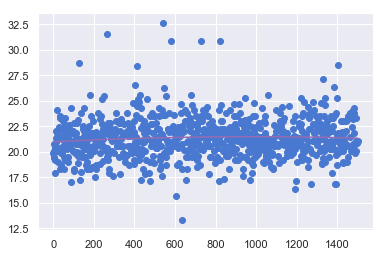

Boulders
r^2 value: 0.0016531445916441179


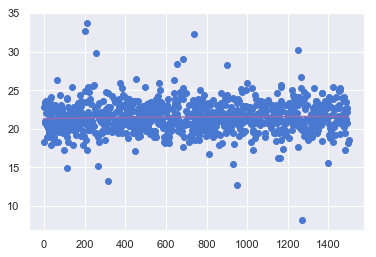

In [46]:
# but can we predict BMI from ranking? again, probably no
def rank_to_bmi(df):
    y = df['bmi']
    x = df['ranking'].astype('int').values.reshape(-1, 1)
    polynomial_features= PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(x)
    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)

    print('r^2 value:', r2_score(y, y_poly_pred))
    plt.scatter(x, y)
    plt.plot(x, y_poly_pred, color='m')
    plt.show()
    
# routes
print('Routes')
df = dfs['RankingRoute'].dropna(axis=0)
rank_to_bmi(df)

# boulder
print('Boulders')
df = dfs['Boulder'].dropna(axis=0)
rank_to_bmi(df)

# and thats a no, which is to be expected if you look at the charts below.